In [1]:
import requests

## Step 1: Get Hospitalization Data
We will retrieve the data from [this file](https://data.cdc.gov/Public-Health-Surveillance/Weekly-United-States-Hospitalization-Metrics-by-Ju/aemt-mg7g/about_data) on data.cdc.gov. This dataset represents weekly respiratory virus-related hospitalization data and metrics aggregated to national and state/territory levels.


In [2]:
hospitalizations_url = (
    "https://data.cdc.gov/resource/aemt-mg7g.json?jurisdiction=NC"
)
hosp_file = requests.get(hospitalizations_url)
hosp_file = hosp_file.json()
hosp_data = []
last_number = 0
for row in hosp_file:
    admissions = int(row.get("total_admissions_all_covid_confirmed"))
    new_row = {
        "week_end_date": row.get("week_end_date"),
        "hospitalizations": last_number + admissions,
    }
    last_number += admissions
    hosp_data.append(new_row)

## Step 2: Get Vaccination Uptake Data
Next we will get the vaccination update data from [this file](https://data.cdc.gov/Vaccinations/COVID-19-Vaccinations-in-the-United-States-Jurisdi/unsk-b7fc/about_data) on data.cdc.gov. This dataset contains overall US COVID-19 Vaccine deliveries and administration data at national and jurisdiction level.

In [3]:
vaccinations_url = "https://data.cdc.gov/resource/unsk-b7fc.json?location=NC"
vacc_file = requests.get(vaccinations_url)
vacc_file = vacc_file.json()
vacc_data = []
for row in vacc_file:
    new_row = {"date": row.get("date"), "vaccinations": row.get("administered")}
    vacc_data.append(new_row)

In [4]:
print(vacc_data[0])
print(hosp_data[0])

{'date': '2023-05-10T00:00:00.000', 'vaccinations': '19434544'}
{'week_end_date': '2020-08-08T00:00:00.000', 'hospitalizations': 852}


## Step 3: Harmonize
The data is not at the same time resolution, and one is cumulative and the other is raw counts. We can harmonize this data by defaulting to the one week timepoint.

In [5]:
harmonized = []
for row in hosp_data:

    def match_dates(x):
        return x.get("date") == row.get("week_end_date")

    matching_vacc_rows = list(filter(match_dates, vacc_data))

    if len(matching_vacc_rows):
        row["vaccinations"] = matching_vacc_rows[0].get("vaccinations")
        harmonized.append(row)

In [6]:
import pandas as pd
as_df = pd.DataFrame(harmonized)
print(as_df)

              week_end_date  hospitalizations vaccinations
0   2020-12-19T00:00:00.000             23316         8784
1   2020-12-26T00:00:00.000             25855        50570
2   2021-01-02T00:00:00.000             28571       102399
3   2021-01-09T00:00:00.000             31713       194478
4   2021-01-16T00:00:00.000             34791       374216
..                      ...               ...          ...
73  2022-05-14T00:00:00.000            122811     16863803
74  2022-05-21T00:00:00.000            123401     16933953
75  2022-05-28T00:00:00.000            124086     17015647
76  2022-06-04T00:00:00.000            124886     17078454
77  2022-06-11T00:00:00.000            125652     17143393

[78 rows x 3 columns]


## Step 4: Visualize
Here we use matplotlib to visualize outputs and check coherence.

/Users/alex/Documents/chip490_335/lecture_artifacts/lecture_20/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


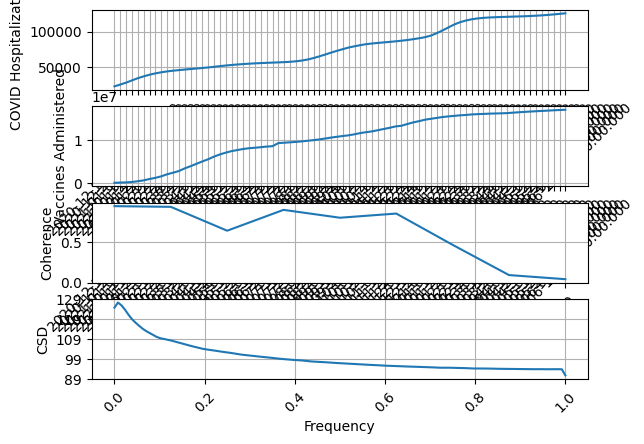

In [7]:
import matplotlib.pyplot as plt

dates = [w.get("week_end_date") for w in harmonized]
covid = [int(w.get("hospitalizations")) for w in harmonized]
vaccines = [int(w.get("vaccinations")) for w in harmonized]
fig, axs = plt.subplots(4, 1, layout="constrained")
axs[0].plot(dates, covid)
axs[0].tick_params(axis="x", labelrotation=45)
axs[0].set_xlabel("Date")
axs[0].set_ylabel("COVID Hospitalizations")
axs[0].grid(True)

axs[1].plot(dates, vaccines)
axs[1].set_xlabel("Date")
axs[1].tick_params(axis="x", labelrotation=45)
axs[1].set_ylabel("Vaccines Administered")
axs[1].grid(True)

axs[2].cohere(covid, vaccines, NFFT=16)
axs[2].set_ylabel("Coherence")
axs[2].tick_params(axis="x", labelrotation=45)

axs[3].csd(covid, vaccines)
axs[3].set_ylabel("CSD")
axs[3].tick_params(axis="x", labelrotation=45)

plt.show()